---

## Imports

In [1]:
import numpy as np 
from pathlib import Path 
import xarray as xr 
import xesmf as xe 
print('xesmf version:', xe.__version__)

# suppress warnings (for clarity)
import warnings
warnings.filterwarnings('ignore')

xesmf version: 0.8.7


## Read in unstructured data (MPAS grid)

In [2]:
mpas_path = Path('/glade/campaign/mmm/wmr/skamaroc/NSC_2023/3.75km_simulation_output_save/')
# see how many timesteps you would like to read in at the same time
file_names = list(mpas_path.glob('diag.3.75km.2020-07-01*10*00.nc'))
file_names.sort()
len(file_names)

2

### Which variable to track on? 

Here we choose the **total ice water path** since the vertically integrated amount of frozen hydrometeors is an indicator for deep convection, since updrafts in deep convective clouds transport moist air high into the troposphere. 

This can be replaced with any other proxy for deep convection or variable of interest. 

In [3]:
# read in data for one day 
var = 'ice_water_path' 

for fname in file_names: 
    ds = xr.open_dataset(fname)[var].compute()
    if fname == file_names[0]:
        ice_water_path = ds
    else:
        ice_water_path  = xr.concat([ice_water_path, ds], dim = 'Time')

In [4]:
print(ice_water_path)

<xarray.DataArray 'ice_water_path' (Time: 2, nCells: 41943042)> Size: 336MB
array([[5.8202648e-01, 3.6065266e-01, 5.1275212e-01, ..., 6.7242084e-04,
        6.2024902e-04, 6.4190075e-04],
       [3.9310162e-03, 4.4740196e-03, 1.9610457e-03, ..., 8.7809196e-05,
        3.4328237e-05, 3.8801434e-05]], dtype=float32)
Dimensions without coordinates: Time, nCells
Attributes:
    units:      g m^{-2}
    long_name:  vertical integral of rho (qi+qs+qg)


## Regridding with **esmpy**

#### Source grid information

To define the source grid, we need information on the lat/lon values for each grid cell on the unstructured grid. 

In [5]:
# Read in grid information for our MPAS simulation
static_file_path = Path('/glade/campaign/mmm/wmr/skamaroc/NSC_2023')
grid = xr.open_dataset(static_file_path / 'x1.41943042.static.nc')

# Get lat/lon values from MPAS grid file 
lat_cell = grid['latCell'].values * 180 / np.pi  # radians to degrees
lon_cell = grid['lonCell'].values * 180 / np.pi

# Assign these coordinates to data 
ice_water_path.coords['lat'] = (('nCells',), lat_cell)
ice_water_path.coords['lon'] = (('nCells',), lon_cell)

# Source dataset: 1d array with attached lat/lon values 
source_ds = xr.Dataset({
    'lat': (['points'], lat_cell),
    'lon': (['points'], lon_cell),
    'ice_water_path': (['points'], ice_water_path.isel(Time=0).values)
})

#### Target grid information

In [7]:
# Define the latitude and longitude ranges with 0.1-degree spacing
latitudes = np.arange(-90, 90.1, 0.1) 
longitudes = np.arange(0, 360.1, 0.1)  
lat, lon = np.meshgrid(latitudes, longitudes)

# Create an xarray Dataset for the target lat-lon grid 
target_grid = xr.Dataset({'lat': (['lat'], latitudes),'lon': (['lon'], longitudes)}) 

#### Regridder class 

This step only needs to be done once, since the class contains information about the grid structure that stays the same for each time step.

In [8]:
regridder = xe.Regridder(
    source_ds,  # just one timestep
    target_grid,
    method='nearest_s2d',
    locstream_in=True,
    reuse_weights=False)

### Loop through the time steps 

In [9]:
regridded_list = []
for t in range(len(ice_water_path.Time)):
    print(f"Regridding timestep {t} for variable {ice_water_path.name}: {ice_water_path.long_name}")
    data_timestep = ice_water_path.isel(Time= t)

    # Apply regridding
    regridded_t = regridder(data_timestep)
    regridded_t = regridded_t.expand_dims(time=[ice_water_path.Time.values[t]])
    regridded_list.append(regridded_t)

# Concatenate all timesteps
regridded_all = xr.concat(regridded_list, dim='time')

Regridding timestep 0 for variable ice_water_path: vertical integral of rho (qi+qs+qg)
Regridding timestep 1 for variable ice_water_path: vertical integral of rho (qi+qs+qg)


### Visualize output 

In [11]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

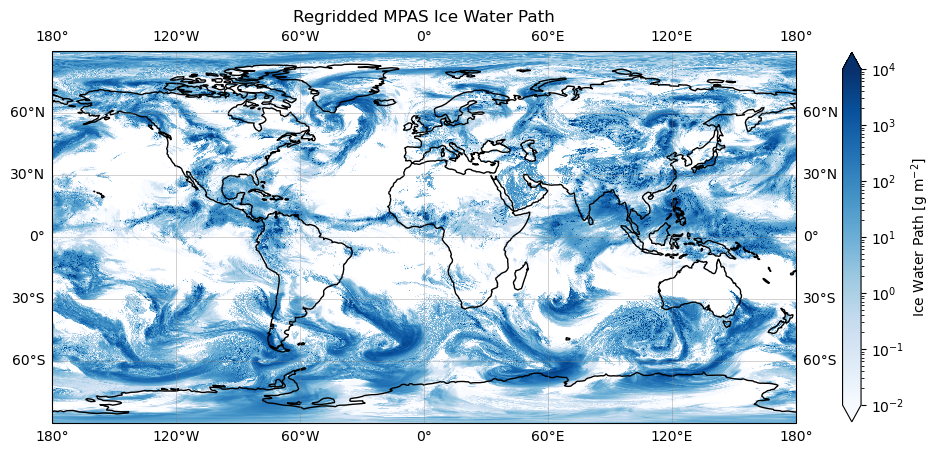

In [10]:
# plot first timestep
regridded = regridded_all.isel(time=0)

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # PlateCarree expects lat/lon coords

# Plot the DataArray using xarray's plot function, but give it the axis
regridded.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  
    cmap='Blues',
    norm=LogNorm(vmin=1e-2, vmax=1e4),
    cbar_kwargs={'label': 'Ice Water Path [g m$^{-2}$]', 'shrink': 0.8}
)

# Add coastlines
ax.coastlines(resolution='110m', linewidth=1)

# Optional: add gridlines
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)

plt.title('Regridded MPAS Ice Water Path')
plt.show()

### Save regridded data (optional, but practical in most cases)

In [26]:
# Add meta data 

# Times 
start = np.datetime64('2020-07-01T10:00:00')
end = np.datetime64('2020-07-01T10:30:00')
times = np.arange(start, end + np.timedelta64(1, 's'), np.timedelta64(30, 'm'))
regridded_all = regridded_all.assign_coords(time=times)

# Rename the variable
regridded_all.name = "ice_water_path"

# Assign attributes
regridded_all.attrs.update({
    'units': 'g m^-2',
    'long_name': 'Ice Water Path',
    'regrid_method': 'nearest_s2d',
    'source': 'MPAS-A DYAMOND 3',
    'comment': 'Regridded from MPAS unstructured mesh to 0.1° lat-lon grid'})

In [28]:
#save to netCDF file 
regridded_all.to_netcdf("mpas_ice_water_path_regridded.nc")

---

## Resources and references

- The full documentation of **xESMF** on **[Readthedocs](https://xesmf.readthedocs.io/en/stable/)**
- Alternative regridding methods (not covered in this cookbook):
  * [ESMF](https://earthsystemmodeling.org/docs/release/latest/ESMF_refdoc/) - Fortran, not the Python interface
  * [TempestRemap](https://github.com/ClimateGlobalChange/tempestremap)
  * [CDO](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html)
